**LIBRARY IMPORTS**

Imported necessary libraries for the project 

In [1]:
from bs4 import BeautifulSoup
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout

**HELPER FUNCTIONS**

Below are all the functions that are used to preprocess the data.

In [2]:
#Removing html related characters from the text.
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

#Removing all non alphabetical characters from the text.
def removeSpecialChars(text):
    pattern = r'[^a-z ]'
    return re.sub(pattern, '', text)

#Converting all upper-case characters to lower case to ensure all text are in the same format for processing.
def convert_to_lower(text):
    new_text = ""
    for i in text:
        if isinstance(i,str):
            new_text = new_text + i.lower()
        else:
            new_text = new_text + i
    return new_text

#Removing stopwords that do not contribute to the meaning of a sentence.
stopWords = set(stopwords.words('english'))
def removeEndChars(text):
    filteredText = []
    for word in text:
        if word not in stopWords:
            filteredText.append(word)
    return filteredText

#Stemming the words to reduce all the words to their roots.
snowStemmer = SnowballStemmer(language='english')
def applyStemmer(text):
    stemmedText = []
    for word in text:
        word = snowStemmer.stem(word)
        stemmedText.append(word)
    return stemmedText

#Joining the list together into a single string separated by spaces.
def concatenateStrings(string_list):
    return ' '.join(string_list)

def process_df(x):
    prompts = parse_text(scores.loc[x,'code'])
    if prompts:
        score = scores.loc[x,'grade']
        df.loc[len(df)] = [prompts,score]

def parse_text(code):
    url = f"./dataset/{code}.html"
    with open(url, 'r', encoding='latin-1') as f:
        contents = f.read()
        soup = BeautifulSoup(contents, 'html.parser')
        body = soup.find(id="__next")
        desired_divs = body.find_all("div",{"data-message-author-role": "user"})
        text = " ".join(paragraph.get_text() for paragraph in desired_divs)
        text = remove_html_tags(text)
        text = convert_to_lower(text)
        text = removeSpecialChars(text)
        text = word_tokenize(text)
        text = removeEndChars(text)
        text = applyStemmer(text)
        text = concatenateStrings(text)
    return text


**DATA PREPROCESSING**

Preprocessing the data before it is fed to the machine learning algorithm.

In [3]:
#Creating df to be used for our model.
df = pd.DataFrame()
df = pd.DataFrame(columns=['prompts','score'])
scores = pd.read_csv("./scores.csv")

In [4]:
#Applying all preprocessing from process_df() function.
scores['idx'].map(lambda x: process_df(x))

0      None
1      None
2      None
3      None
4      None
       ... 
140    None
141    None
142    None
143    None
144    None
Name: idx, Length: 145, dtype: object

In [5]:
#Display of processed text from ChatGPT prompts.
df.map(lambda x: print(x))

say intern energi ideal gase depend solali temperatur
display variabl name panda datafram check miss valu panda datafram fill miss part common valu column also want check type column float want use mean instead mode want encod categor label use follow mapsexmap femal male islandmap bisco dream torgensen dietmap fish krill squid parentallifestagemap chick juvenil adult healthmetricsmap healthi overweight underweight shuffl dataset use sklearnutilsshuffl want split dataset train test use test size healthmetr column name want calcul correl target variabl featur x plot result use seaborn sns featur name speci object type also want see correl select featur strong predictor use correl heatmap propos hypothet featur might enhanc model predict accuraci pleas also explain may deriv expect impact want train decis tree classifi tune hyper paramet use cross valid valu use gridsearchcv valid accuraci pick best hyper paramet grid follow criterion gini entropi logloss maxfeatur auto sqrt log get foll

,prompts,score
0,None,None
1,None,None
2,None,None
3,None,None
4,None,None
...,...,...
136,None,None
137,None,None
138,None,None
139,None,None


**BUILDING THE MODEL**

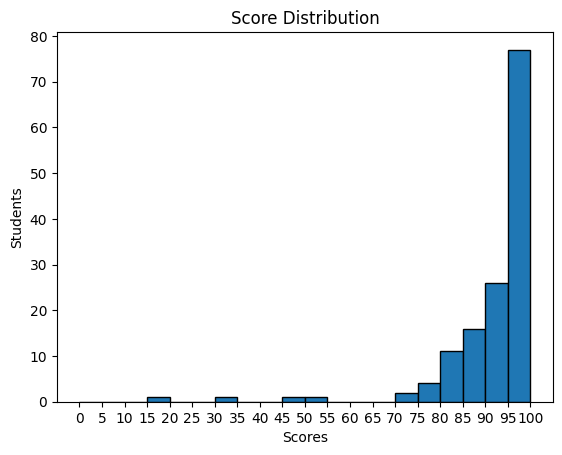

In [6]:
#Visualizing scores provided
plt.hist(df['score'], bins=np.arange(0, 105, 5), edgecolor='black')
plt.xlabel('Scores')
plt.ylabel('Students')
plt.title('Score Distribution')
plt.xticks(np.arange(0, 105, 5))
plt.show()

In [7]:
# To avoid overfitting I've generalized the model so that the algorithm predicts the score 
# of the student on a scale from 0 to 4 where corresponding score gap is provided below:
def encode_value(x):
    if 80 < x <= 85:
        return 1
    elif 85 < x <= 90:
        return 2
    elif 90 < x <= 95:
        return 3
    elif 95 < x <= 100:
        return 4
    else:
        return 0  # INVALID DATA
    
df['score'] = df['score'].apply(encode_value)

In [8]:
#Splitting tran and test data
df_shuffled = shuffle(df, random_state=42)
X = df_shuffled['prompts']
y = df_shuffled['score']
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42)
print(y)

68     4
108    3
31     2
51     4
95     4
      ..
71     3
106    4
14     1
92     4
102    3
Name: score, Length: 141, dtype: int64


In [9]:
#Creating dictionary for training data
vocab_count = dict()
for line in train_data:
    line = line.split()
    for word in line: 
        if word not in vocab_count:
            vocab_count[word] = 0
        else:
            vocab_count[word] +=1
        
vocab = np.array(list(vocab_count.keys()))
print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 5379


In [10]:
max_features = 500 # using a number close to %10 of the vocabulary size above (5379)
vectorizer = CountVectorizer(max_features=max_features, preprocessor=lambda x:x)
vectorizer.fit(train_data)
train_bow = vectorizer.transform(train_data)
test_bow = vectorizer.transform(test_data)

In [11]:
#Converting our data to categorical
train_labels_one_hot = to_categorical(train_labels, num_classes=5)
test_labels_one_hot = to_categorical(test_labels, num_classes=5)

In [58]:
train_bow_dense = train_bow.toarray()
test_bow_dense = test_bow.toarray()

model = Sequential([
    Dense(128, activation='relu', input_shape=(max_features,)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(train_bow_dense, train_labels_one_hot, epochs=10, batch_size=16, validation_split=0.2)

C:\Users\pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 128)               │     64,128 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_30 (Dropout)            │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_46 (Dense)                │ (None, 64)                │      8,256 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_31 (Dropout)            │ (None, 64)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_47 (Dense)                │ (None, 5)                 │        325 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 72,709 (284.02 KB)

 Trainable params: 72,709 (284.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2590 - loss: 3.2539 - val_accuracy: 0.4783 - val_loss: 1.6470
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4459 - loss: 2.8459 - val_accuracy: 0.4783 - val_loss: 1.5134
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3875 - loss: 2.3324 - val_accuracy: 0.4348 - val_loss: 1.3774
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3482 - loss: 1.8690 - val_accuracy: 0.3478 - val_loss: 1.4383
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4490 - loss: 1.5207 - val_accuracy: 0.3478 - val_loss: 1.4612
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5145 - loss: 1.3222 - val_accuracy: 0.3478 - val_loss: 1.4521
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4726 - loss: 1.4323 - val_accuracy: 0.3043 - val_loss: 1.4792
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4568 - loss: 1.4120 - val_accuracy: 0.4783 - val_loss: 1.4082
Epoch 9

In [59]:
test_loss, test_accuracy = model.evaluate(test_bow_dense, test_labels_one_hot)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5862 - loss: 1.6164
Test Loss: 1.6164419651031494
Test Accuracy: 0.5862069129943848


**RESULT**

After hyperparameter tuning the parameters used above provided the best accuracy with 58%.

Althrough %58 may seem insignificant, considering the wide range of possible scores, achieving %58 to determine the average score with 2.5 scores of variance at most is I believe a succesful model.

In this specific project I've realized that the resulting models would be extremely prone to overfitting thus I've developed the model and preprocessed the data in a way to generalize the input and output as much as I can hence why question based processing is not done, the output score is a 5 point gap instead of a precise score and other design choices along the way.

Below is the demonstration of the model on a histogram to visualize the output.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step


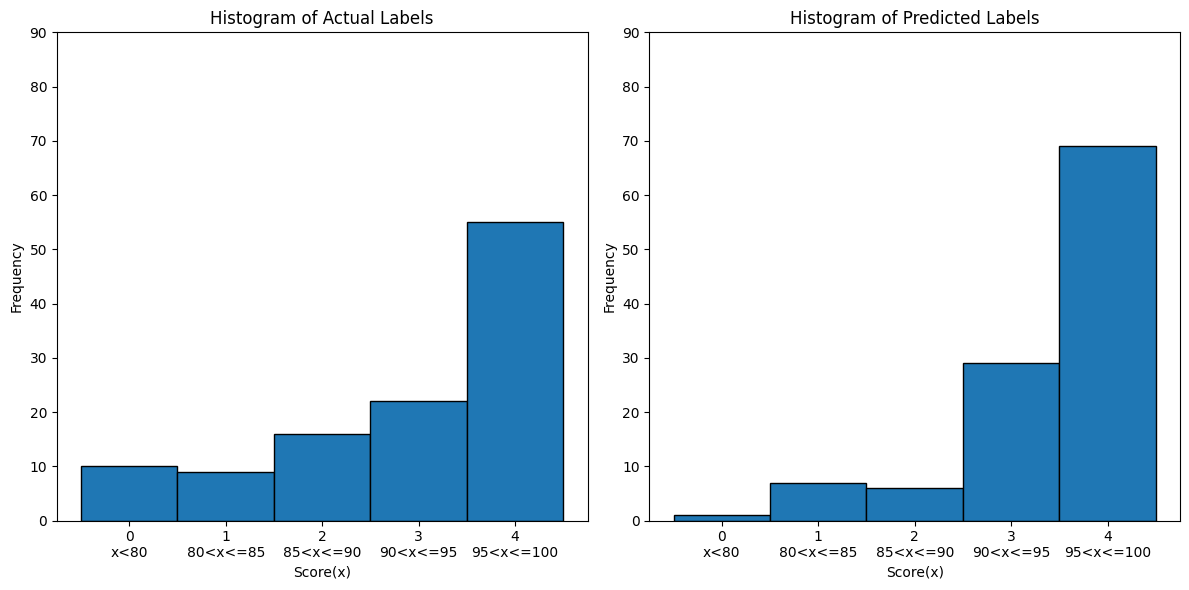

In [65]:
import matplotlib.pyplot as plt
import numpy as np
predicted_labels = model.predict(train_bow_dense)
predicted_labels_processed = np.argmax(predicted_labels, axis=1)
actual_labels = np.argmax(train_labels_one_hot, axis=1)
xtick_locations = np.arange(0.5,5.5)
xtick_labels = ['0\nx<80', '1\n80<x<=85', '2\n85<x<=90', '3\n90<x<=95', '4\n95<x<=100']
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(actual_labels, bins=np.arange(0,6), edgecolor='black')
plt.title('Histogram of Actual Labels')
plt.xlabel('Score(x)')
plt.ylabel('Frequency')
plt.yticks(np.arange(0,100,10))
plt.xticks(xtick_locations, xtick_labels)
plt.subplot(1, 2, 2)
plt.hist(predicted_labels_processed, bins=np.arange(0,6), edgecolor='black')
plt.title('Histogram of Predicted Labels')
plt.xlabel('Score(x)')
plt.ylabel('Frequency')
plt.yticks(np.arange(0,100,10))
plt.xticks(xtick_locations, xtick_labels)

plt.tight_layout()
plt.show()